In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Black-Scholes hedging strategy

We define $T>0$. For $n\in\mathbb{N}^*$ and $i\in\{0,...,n\}$, we define $\delta T=T/n$ and $t_i^n=i\delta T$.

Let $W$ be a Brownian motion and $S$ a stochastic process s.t
$$S_t=S_0 e^{(\mu-\sigma^2/2)t+\sigma W_t}, \; t\ge0$$
where $\mu$ and $\sigma$ are respectively the drift rate and the volatility of the process.

We recall that in the Black-Scholes model, under the no-arbitrage condition, the price of an European call option, whose price of the underlying asset is $(S_t)_t$, is

$$BS(S_0,K,T) = S_0 N(d_+(S_0, Ke^{-rT}, \sigma^2 T)) - K e^{-rT} N(d_-(S_0, Ke^{-rT}, \sigma^2 T))$$

where $r$ is the risk-free interest rate, $K$ is the strike, $T$ the maturity, $N$ the standard normal cumulative distribution function and

$$d_\pm(s,k,v) = \frac{\ln(s/k)}{\sqrt v} \pm \frac{\sqrt v }{2}$$

The optimal hedging strategy is to have $\Delta_t$ actions of price $S_t$, defined by

$$\Delta_t = N(d_+(S_t, Ke^{-r(T-t)}, \sigma^2(T-t))), \; 0\le t\le T$$

#### 1.
Write a function that simulates $m=1000$ trajectories, on a discrete grid with $n=1000$ of the process $S$, i.e $m$ trajectories of $(S_{t_i^n})_{0\le i\le n}$.

We shall use $T=1.5$, $S_0=100$, $\sigma = 0.3$ and $\mu\in\{0.02, 0.05, 0.45\}$.

Estimate their average and variance and comment.

In [2]:
def simulate_process(m: int, n: int, T: float, S_0: float, sigma:float, mu: float):

    delta_T = T / n

    ## We first simulate the Brownian motion
    N = norm.rvs(
        scale=np.sqrt(delta_T), # scale argument is the std
        size=(n+1, m),
    )
    W = np.cumsum(N, axis=0)
    
    ## We also create a matrix t, containing the time
    t = np.linspace(0, T, n+1)
    t = np.tile(t.reshape((-1, 1)), (1, m))
    
    ## Then we compute S from W
    S = S_0 * np.exp((mu - sigma**2 / 2) * t + sigma * W)

    return S

In [3]:
m, n, T, S_0, sigma = 10000, 1000, 1.5, 100., .3
MUS = [.02, .05, .45]

S = {
    mu: simulate_process(m=m, n=n, T=T, S_0=S_0, sigma=sigma, mu=mu)
    for mu in MUS
}

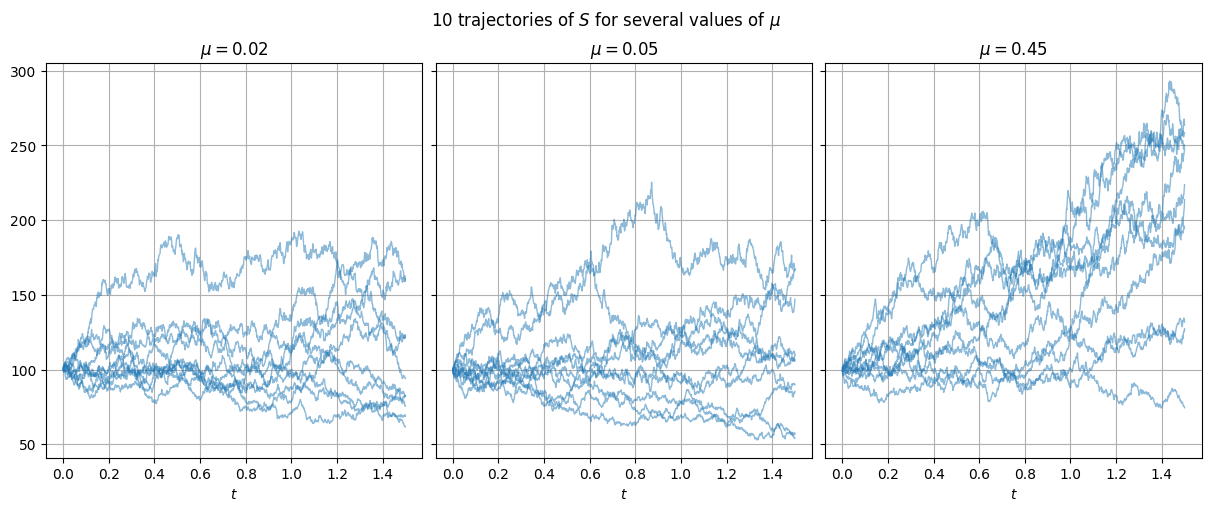

In [4]:
## Let's plot some trajectories
t = np.linspace(0, T, n+1)

fig, axs = plt.subplots(1, 3, figsize=(12, 5), sharex=True, sharey=True, layout="constrained")

for i, mu in enumerate(MUS):
    axs[i].plot(t, S[mu][:,:10], lw=1, c='C0', alpha=.5)
    axs[i].set_xlabel("$t$")
    axs[i].grid()
    axs[i].set_title(f"$\mu={mu}$")

fig.suptitle("10 trajectories of $S$ for several values of $\mu$")
plt.show()

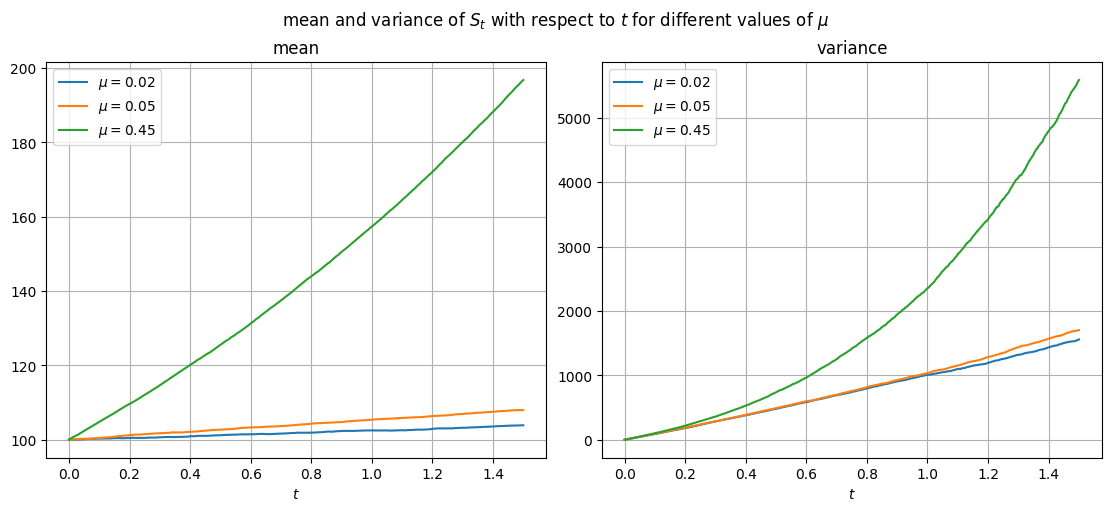

In [5]:
## Let's now plot the means and variances

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(11,5), layout="constrained")

t = np.linspace(0, T, n+1)

for i, mu in enumerate(MUS):
    ax1.plot(t, S[mu].mean(axis=1), label=f"$\mu={mu}$")
ax1.set_xlabel("$t$")
ax1.grid()
ax1.legend(loc='best')
ax1.set_title("mean")

for i, mu in enumerate(MUS):
    ax2.plot(t, S[mu].var(axis=1), label=f"$\mu={mu}$")
ax2.set_xlabel("$t$")
ax2.grid()
ax2.legend(loc='best')
ax2.set_title("variance")

fig.suptitle("mean and variance of $S_t$ with respect to $t$ for different values of $\mu$")
plt.show()

The means and variances look exponential with respect of the time and are increasing in $\mu$. We can test the first hypothesis by plotting the graphs in log scale.

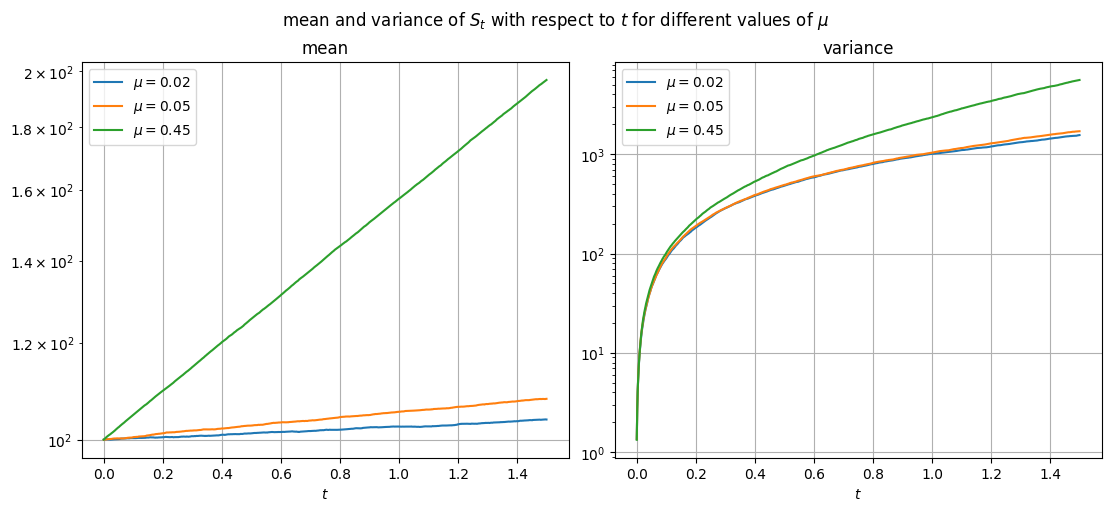

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(11,5), layout='constrained')

t = np.linspace(0, T, n+1)

for i, mu in enumerate(MUS):
    ax1.plot(t, S[mu].mean(axis=1), label=f"$\mu={mu}$")
ax1.set_xlabel("$t$")
ax1.set_yscale('log')
ax1.grid()
ax1.legend(loc='best')
ax1.set_title("mean")

for i, mu in enumerate(MUS):
    ax2.plot(t, S[mu].var(axis=1), label=f"$\mu={mu}$")
ax2.set_xlabel("$t$")
ax2.set_yscale('log')
ax2.grid()
ax2.legend(loc='best')
ax2.set_title("variance")

fig.suptitle("mean and variance of $S_t$ with respect to $t$ for different values of $\mu$")
plt.show()

We can compute them from the process formula:

$$\mathbb{E} [S_t] = S_0 e^{(\mu-\sigma^2/2)t} \mathbb E[e^{\sigma W_t}] = S_0 e^{\mu t}$$

$$\mathbb E [S_t^2] = S_0^2 e^{(2\mu-\sigma^2)t} \mathbb E[e^{2\sigma W_t}] = S_0^2 e^{(2\mu+\sigma^2)t}$$

$$\mathbb V(S_t) = \mathbb E [S_t^2] - \mathbb{E} [S_t]^2 = S_0^2 e^{2\mu t} (e^{\sigma^2 t}-1)$$

#### 2.
**a)**
We define
$$X_T^n(S,K) = e^{rT}\Big[BS(S_0, K, T) + \sum_{i=1}^n \Delta_{t_{i-1}^n}(S_{t_{i-1}^n},K)
\big(e^{-rt_i^n}S_{t_i^n} - e^{-rt_{i-1}^n}S_{t_{i-1}^n}\big)\Big]
$$

Simulate $m=10000$ realisations of $X_T^n(S,K)$ for each three values of $\mu$. We shall use $r=0.05$ and $K\in\{80, 82, 84, ..., 120\}$.


In [7]:
def compute_BS(sigma:float, r: float, S_0: float, K: np.ndarray, T: float):

    """
    Compute the European call option price in Black-Scholes model for
    several values of K, returning an array of shape (len(K))
    """

    k = K * np.exp(-r*T)
    v = sigma ** 2 * T
    dplus = np.log(S_0/k) / np.sqrt(v) + np.sqrt(v) / 2
    dminus = np.log(S_0/k) / np.sqrt(v) - np.sqrt(v) / 2

    BS = S_0 * norm.cdf(dplus) - k * norm.cdf(dminus)
    return BS

def compute_Delta_t(sigma: float, r: float, T: float, 
                    S_t: np.ndarray, K:np.ndarray
    ):

    """
    Compute the optimal hedging strategy Delta_t for several values of S_t and K,
    S_t is of shape (n+1, m) with n the amount of timestep
    K is of shape (len(K), )
    The output is an array of shape (n+1, m, len(K)).
    """

    n = len(S_t) - 1
    m = len(S_t[0])

    t = np.tile(
        np.linspace(0, T, n+1).reshape(-1, 1, 1), 
        (1, m, len(K))
    ) # t.shape = (n+1, m, len(K))

    s = np.tile(S_t.reshape(n+1, m, 1), (1, 1, len(K)))
    k = np.exp(-r * (T - t)) * np.tile(K, (n+1, m, 1))
    v = sigma ** 2 * (T - t)
    dplus = np.log(s / k) / np.sqrt(v) + np.sqrt(v) / 2
    return norm.cdf(dplus)

In [8]:
def simulate_X(n: int, sigma: float, mu:float, r: float, T: float, S_0:float,
               m: int, K: np.ndarray
    ):

    """
    Simulate X_T^n (S,K) m times for each value of K, returning an array of size (m, len(K))
    """

    S = simulate_process(m, n, T, S_0, sigma, mu)
    BS = compute_BS(sigma, r, S_0, K, T)
    Delta_t = compute_Delta_t(sigma, r, T, S, K)

    ## We compute the matrix corresponding to the leftmost parantheses of the formula
    S_tilde = S * np.exp(-r * np.linspace(0, T, n+1)).reshape(-1, 1)
    # S_tilde shape is (n+1, m) 
    M = S_tilde[1:] - S_tilde[:-1]
    M = np.tile(M.reshape(n, m, 1), (1, 1, len(K)))
    # M shape is (n, m, len(K))

    X = np.exp(r*T) * (
        np.tile(BS, (m, 1))
        + np.sum(Delta_t[:-1] * M, axis=0)
    )

    return X

In [9]:
K = np.arange(80, 122, 2)
n, sigma, r, T, S_0 = 1000, .3, .05, 1.5, 100.
m = 2000

X = {
    mu: simulate_X(n=n, sigma=sigma, mu=mu, r=r, T=T, S_0=S_0, m=m, K=K)
    for mu in MUS
}

C:\Users\thomb\AppData\Local\Temp\ipykernel_22904\1138669175.py:38: RuntimeWarning: divide by zero encountered in divide
  dplus = np.log(s / k) / np.sqrt(v) + np.sqrt(v) / 2


**b)**
Compute the empirical mean and variance for these three random variables

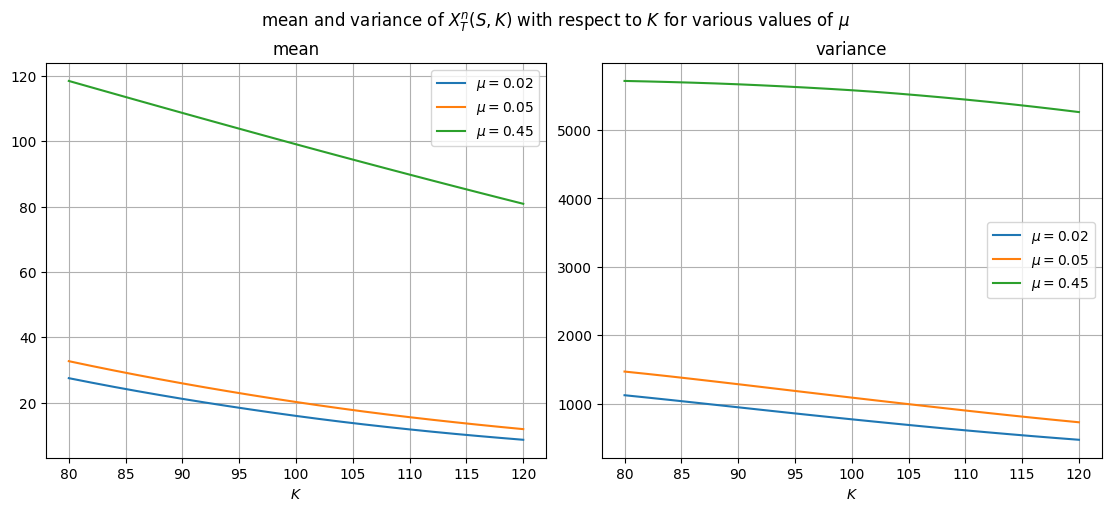

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(11,5), layout="constrained")

for mu in MUS:
    ax1.plot(K, X[mu].mean(axis=0), label=f"$\mu={mu}$")
ax1.set_xlabel('$K$')
ax1.grid()
ax1.legend(loc='best')
ax1.set_title("mean")

for mu in MUS:
    ax2.plot(K, X[mu].var(axis=0), label=f"$\mu={mu}$")
ax2.set_xlabel('$K$')
ax2.grid()
ax2.legend(loc='best')
ax2.set_title("variance")

fig.suptitle("mean and variance of $X_T^n(S,K)$ with respect to $K$ for various values of $\mu$")
plt.show()

**c)**
Compute corresponding gains and losses:
$$PL_T^n(S,K)=X_T^n(S,K)-(S_T-K)^+$$

In [11]:
## We won't use the function simulate_X we just implemented because PL also depends on S_T

def simulate_PL(n: int, sigma: float, mu:float, r: float, T: float, S_0:float,
               m: int, K: np.ndarray
    ):

    """
    Simulate PL_T^n(S,K) m times for each value of K, returning an array of size (m, len(K))
    """

    S = simulate_process(m, n, T, S_0, sigma, mu)

    ## We first simulate X, as we already implemented
    BS = compute_BS(sigma, r, S_0, K, T)
    Delta_t = compute_Delta_t(sigma, r, T, S, K)
    S_tilde = S * np.exp(-r * np.linspace(0, T, n+1)).reshape(-1, 1)
    M = S_tilde[1:] - S_tilde[:-1]
    M = np.tile(M.reshape(n, m, 1), (1, 1, len(K)))
    X = np.exp(r*T) * (
        np.tile(BS, (m, 1))
        + np.sum(Delta_t[:-1] * M, axis=0)
    )

    ## We then compute the call option payoff, using the same process S
    call_option_payoff = np.maximum(
        np.tile(S[-1].reshape(-1, 1), (1, len(K))) - np.tile(K, (m, 1)),
        np.zeros((m, len(K)))
    )

    return X - call_option_payoff

**d)**
For each value of $\mu$, display the empirical mean and variance of $PL_T^n(S,K)$ as a function of $K$. Then, do it again with a lower $n$ and compare.

In [12]:
K = np.arange(80, 122, 2)
sigma, r, T, S_0 = .3, .05, 1.5, 100.
m = 2000

PL = {
    (mu, 1000): simulate_PL(n=1000, sigma=sigma, mu=mu, r=r, T=T, S_0=S_0, m=m, K=K)
    for mu in MUS
}

C:\Users\thomb\AppData\Local\Temp\ipykernel_22904\1138669175.py:38: RuntimeWarning: divide by zero encountered in divide
  dplus = np.log(s / k) / np.sqrt(v) + np.sqrt(v) / 2


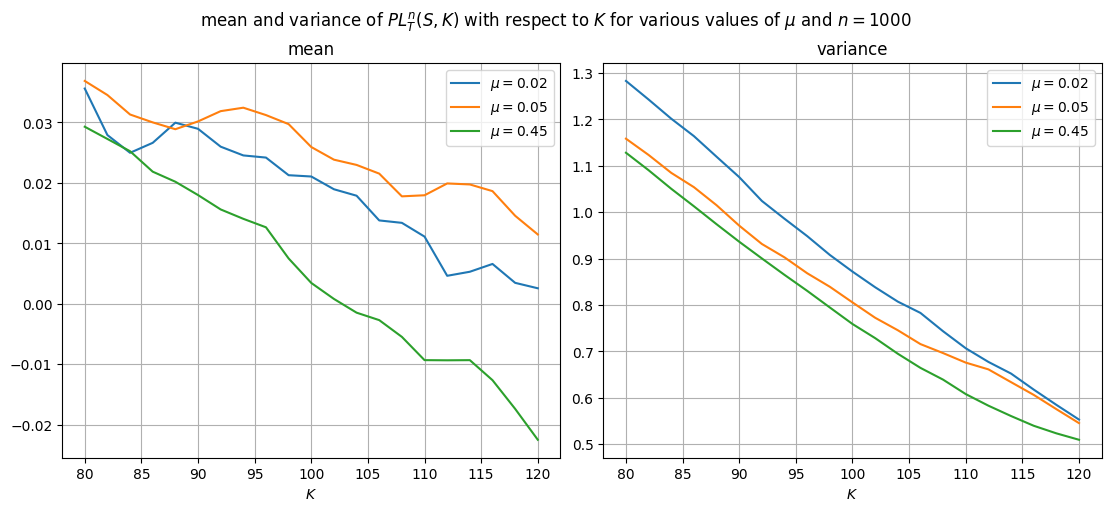

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(11,5), layout='constrained')

for mu in MUS:
    ax1.plot(K, PL[(mu, 1000)].mean(axis=0), label=f"$\mu={mu}$")
ax1.set_xlabel('$K$')
ax1.grid()
ax1.legend(loc='best')
ax1.set_title("mean")

for mu in MUS:
    ax2.plot(K, PL[(mu, 1000)].var(axis=0), label=f"$\mu={mu}$")
ax2.set_xlabel('$K$')
ax2.grid()
ax2.legend(loc='best')
ax2.set_title("variance")

fig.suptitle("mean and variance of $PL_T^n(S,K)$ with respect to $K$ for various values of $\mu$ and $n=1000$")
plt.show()

In [14]:
PL |= {
    (mu, 100): simulate_PL(n=100, sigma=sigma, mu=mu, r=r, T=T, S_0=S_0, m=m, K=K)
    for mu in MUS
}

C:\Users\thomb\AppData\Local\Temp\ipykernel_22904\1138669175.py:38: RuntimeWarning: divide by zero encountered in divide
  dplus = np.log(s / k) / np.sqrt(v) + np.sqrt(v) / 2


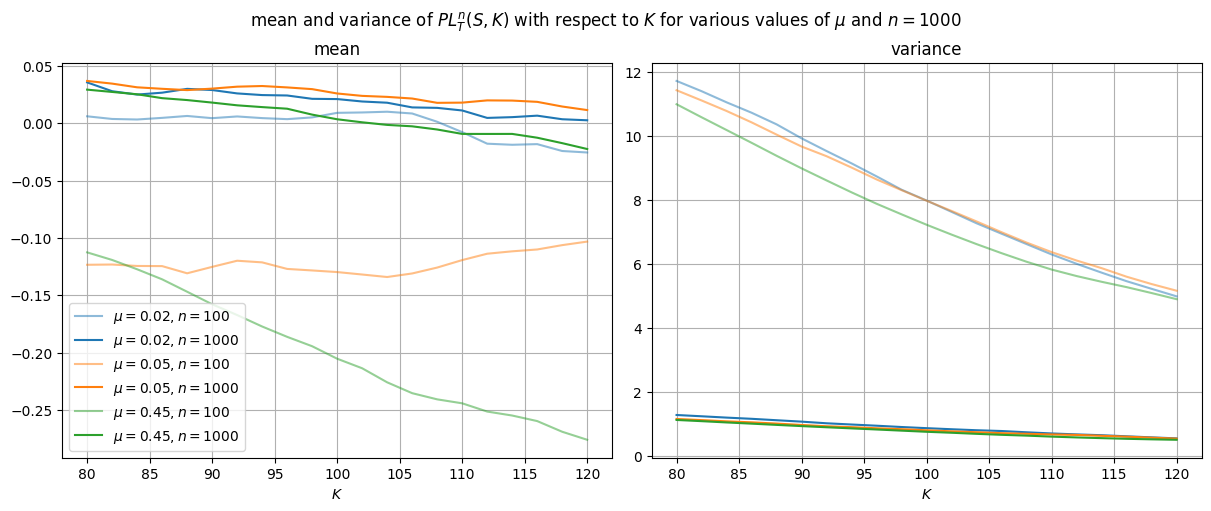

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12,5), layout="constrained")

for mu in MUS:
    for n in (100, 1000):
        ax1.plot(
            K, PL[(mu, n)].mean(axis=0), 
            label=f"$\mu={mu}, n={n}$", 
            c=("C0" if mu==.02 else ("C1" if mu==.05 else "C2")), 
            alpha=(1 if n==1000 else .5),
        )
ax1.set_xlabel('$K$')
ax1.grid()
ax1.legend(loc='best')
ax1.set_title("mean")

for mu in MUS:
    for n in (100, 1000):
        ax2.plot(
            K, PL[(mu, n)].var(axis=0), 
            label=f"$\mu={mu}, n={n}$", 
            c=("C0" if mu==.02 else ("C1" if mu==.05 else "C2")), 
            alpha=(1 if n==1000 else .5),
        )
ax2.set_xlabel('$K$')
ax2.grid()
#ax2.legend(loc='best')
ax2.set_title("variance")

fig.suptitle("mean and variance of $PL_T^n(S,K)$ with respect to $K$ for various values of $\mu$ and $n=1000$")
plt.show()